In [1]:

import time
import copy

import numpy as np
import torch

from patch_seg import handle_patch_update_in_epoch_step
from model_utils import debug_memory
from loss import get_batch_loss
from viz import save_patches_image
from unet3d import UNet #RootPainter UNet
import nibabel as nib
from matplotlib import pyplot as plt
from patchify import patchify
from torch.utils.data import Dataset, DataLoader
from scipy.ndimage import distance_transform_edt
from skimage.metrics import mean_squared_error

In [20]:
class FiberData(Dataset):
    def __init__(self, inputs, labels):
        inputs = (inputs - np.min(inputs))/(np.max(inputs)- np.min(inputs))
        # labels = (inputs - np.min(labels))/(np.max(labels)- np.min(labels))
        print(f"input sizes {inputs.shape=}, {labels.shape=}")
        inputs = patchify(inputs, (116, 116, 116), step=82)
        print(f"patchified {inputs.shape=}")
        labels = patchify(labels, (116, 116, 116), step=82)
        print(f"patchified {labels.shape=}")
        numd1, numd2, numd3, _,_,_ = inputs.shape
        inputs = inputs.reshape(numd1*numd2*numd3, 116, 116, 116)
        labels = labels.reshape(numd1*numd2*numd3, 116, 116, 116)
        self.inputs = inputs
        self.labels = labels
        # print(f"{len(inputs)}")
        # print(f"{inputs.shape}")
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        input = self.inputs[idx]
        label = self.labels[idx]
        # print(f"{input.shape=}, {label.shape=}")
        input = np.expand_dims(input, 0)
        input = torch.from_numpy(np.array(input)).cuda()
        label = label[17:-17,17:-17,17:-17]
        label = np.expand_dims(label, 0)
        label = torch.from_numpy(np.array(label)).cuda()
        return input, label

In [21]:
def get_nii_array(path):
    img = nib.load(path)
    img = np.array(img.dataobj).astype(np.float32)
    return img

input = get_nii_array("im02.nii.gz")
label = get_nii_array("59_edt_labels.nii.gz")
_, a2, _ = input.shape


# 45 % test, 30 % val and 25 % test
val_idx = int(np.floor(a2*0.50))
test_idx = int(val_idx+np.floor(a2*0.25))
train_input = input[:, :val_idx, :]
train_label = label[:, :val_idx, :]
val_input = input[:, val_idx:test_idx, :]
val_label = label[:, val_idx:test_idx, :]
test_input = input[:, test_idx: ,:]
test_label = label[:, test_idx: ,:]


In [24]:

model = SofUNet3D(1, im_channels=1)
model.load_state_dict(torch.load('3d_edt'))
model.cuda()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
input = get_nii_array("im02.nii.gz")
print(f"image shape {input.shape=}")
label = get_nii_array("59_edt_labels.nii.gz")
_, a2, _ = input.shape

train_dataset = FiberData(train_input, train_label)
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)

val_dataset = FiberData(val_input, val_label)
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=False)

test_dataset = FiberData(test_input, test_label)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=False)




image shape input.shape=(1376, 681, 298)
input sizes inputs.shape=(1376, 340, 298), labels.shape=(1376, 340, 298)
patchified inputs.shape=(16, 3, 3, 116, 116, 116)
patchified labels.shape=(16, 3, 3, 116, 116, 116)
input sizes inputs.shape=(1376, 170, 298), labels.shape=(1376, 170, 298)
patchified inputs.shape=(16, 1, 3, 116, 116, 116)
patchified labels.shape=(16, 1, 3, 116, 116, 116)
input sizes inputs.shape=(1376, 171, 298), labels.shape=(1376, 171, 298)
patchified inputs.shape=(16, 1, 3, 116, 116, 116)
patchified labels.shape=(16, 1, 3, 116, 116, 116)


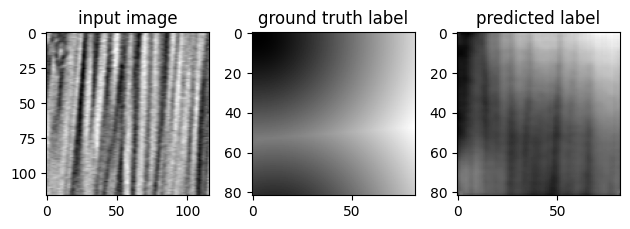

In [31]:

def plot_results(input, label, output):
    rand_batch = np.random.randint(4)
    rand_slice = np.random.randint(16)
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    ax1.set_title("input image")
    a1 = ax1.imshow(input[rand_batch, 0, :, :, rand_slice],cmap='gray')
    # ax1.grid(c='b')
    ax2.set_title("ground truth label")
    a2 = ax2.imshow(label[rand_batch, 0, :, :, rand_slice], cmap='gray')
    # ax2.grid(c='b')
    ax3.set_title("predicted label",)
    a3 = ax3.imshow(output[rand_batch, 0, :, :, rand_slice], cmap='gray')
    # ax3.grid(c='b')
    fig.tight_layout()
    plt.show()


input, label = next(iter(test_dataloader))
output = model(input).cpu().detach().numpy()
label = label.cpu().detach().numpy()
input = input.cpu().detach().numpy()
plot_results(input, label, output)



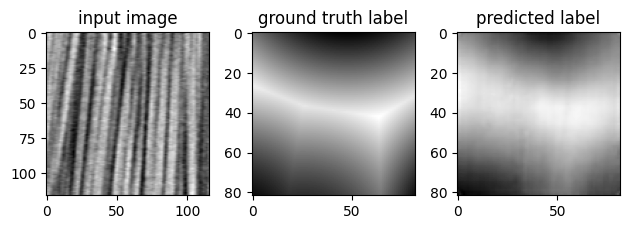

In [176]:
plot_results(input, label, output)


In [68]:
print(train_input.shape)
train_input_p = (train_input - np.min(train_input))/(np.max(train_input)- np.min(train_input))
train_data_pad = np.pad(train_input_p, ((17,116), (17,116), (17,116)), mode="constant")
print(train_data_pad.shape)
c = 0
full_res = np.zeros(train_data_pad.shape)
for x0 in range(0, train_data_pad.shape[0]-116, 82):
    for y0 in range(0, train_data_pad.shape[1]-116, 82):
        for z0 in range(0, train_data_pad.shape[2]-116, 82):
            print(x0, y0, z0)
            input = train_data_pad[x0:x0+116, y0:y0+116, z0:z0+116]
            input = np.expand_dims(input, 0)
            input = np.expand_dims(input, 0)
            input = torch.from_numpy(np.array(input)).cuda()
            out_patch = model(input)
            
            full_res[x0+17:x0+17+82, y0+17:y0+17+82, z0+17:z0+17+82] = out_patch[0][0].cpu().detach().numpy()

            c+=1
            



(1376, 340, 298)
(1509, 473, 431)
0 0 0
0 0 82
0 0 164
0 0 246
0 82 0
0 82 82
0 82 164
0 82 246
0 164 0
0 164 82
0 164 164
0 164 246
0 246 0
0 246 82
0 246 164
0 246 246
0 328 0
0 328 82
0 328 164
0 328 246
82 0 0
82 0 82
82 0 164
82 0 246
82 82 0
82 82 82
82 82 164
82 82 246
82 164 0
82 164 82
82 164 164
82 164 246
82 246 0
82 246 82
82 246 164
82 246 246
82 328 0
82 328 82
82 328 164
82 328 246
164 0 0
164 0 82
164 0 164
164 0 246
164 82 0
164 82 82
164 82 164
164 82 246
164 164 0
164 164 82
164 164 164
164 164 246
164 246 0
164 246 82
164 246 164
164 246 246
164 328 0
164 328 82
164 328 164
164 328 246
246 0 0
246 0 82
246 0 164
246 0 246
246 82 0
246 82 82
246 82 164
246 82 246
246 164 0
246 164 82
246 164 164
246 164 246
246 246 0
246 246 82
246 246 164
246 246 246
246 328 0
246 328 82
246 328 164
246 328 246
328 0 0
328 0 82
328 0 164
328 0 246
328 82 0
328 82 82
328 82 164
328 82 246
328 164 0
328 164 82
328 164 164
328 164 246
328 246 0
328 246 82
328 246 164
328 246 246
328 32

In [69]:
def get_full_result(input_data):
    train_input_p = (input_data - np.min(input_data))/(np.max(input_data)- np.min(input_data))
    train_data_pad = np.pad(train_input_p, ((17,116), (17,116), (17,116)), mode="constant")
    c = 0
    full_res = np.zeros(train_data_pad.shape)
    for x0 in range(0, train_data_pad.shape[0]-116, 82):
        for y0 in range(0, train_data_pad.shape[1]-116, 82):
            for z0 in range(0, train_data_pad.shape[2]-116, 82):
                # print(x0, y0, z0)
                input = train_data_pad[x0:x0+116, y0:y0+116, z0:z0+116]
                input = np.expand_dims(input, 0)
                input = np.expand_dims(input, 0)
                input = torch.from_numpy(np.array(input)).cuda()
                out_patch = model(input)

                full_res[x0+17:x0+17+82, y0+17:y0+17+82, z0+17:z0+17+82] = out_patch[0][0].cpu().detach().numpy()

                c+=1
    return full_res[17:17+input_data.shape[0],17:17+input_data.shape[1],17:17+input_data.shape[2]]
full_val_data = get_full_result(val_input)
full_test_data = get_full_result(test_input)

362
[258 259 257 ... 210 218 226]


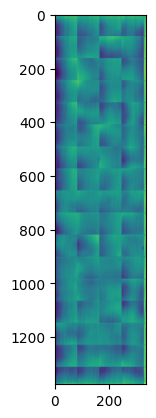

(1376, 170, 298)

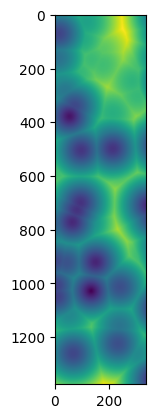

In [67]:
print(246+116)
print(np.where(full_res > 100)[2])

plt.imshow(full_res[17:17+train_label.shape[0],17:17+train_label.shape[1],17:17+train_label.shape[2]][:,:,40])
plt.show()
plt.imshow(train_label[:,:,40])
val_label.shape

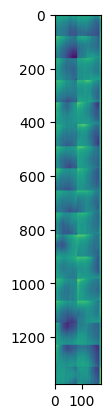

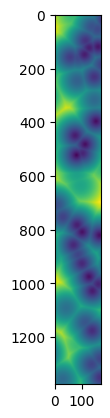

In [76]:
plt.imshow(full_val_data[:,:,90])
plt.show()
plt.imshow(val_label[:,:,90])

In [63]:
# def make_random_guess3D(num_fb, mode="val"):
#     label = get_nii_array("im59_labels.nii.gz")
#     random_guesses = np.ones(label.shape)
#     # for i in range(val_label.shape[2]):
#     #     num_fb = (norm.rvs( 13.75168, 6.99895))
#     #     rand_slice = np.ones((val_label.shape[0], val_label.shape[1]))
#     for j in range(int(num_fb)):
#         random_guesses[np.random.randint(random_guesses.shape[0]), np.random.randint(random_guesses.shape[1]), np.random.randint(random_guesses.shape[2])] = 0
#     guess_edt = distance_transform_edt(random_guesses)
#     if mode == "train":
#         guess_edt = guess_edt[:, :val_idx, :]
#     elif mode == "val":
#         guess_edt = guess_edt[:, val_idx:test_idx, :]
#     guess_labels = patchify(guess_edt, (116, 116, 116), step=100)
#     numd1, numd2, numd3, _,_,_ = guess_labels.shape
#     guess_labels = guess_labels.reshape(numd1*numd2*numd3, 116, 116, 116)
    
#     return guess_labels

def make_random_guess3D(data_inputs, num_fb=371):
    random_guesses = np.ones(data_inputs.shape)
    for j in range(int(num_fb)):
        random_guesses[np.random.randint(random_guesses.shape[0]), np.random.randint(random_guesses.shape[1]), np.random.randint(random_guesses.shape[2])] = 0
    guess_edt = distance_transform_edt(random_guesses)
    return guess_edt


        

In [80]:
from skimage.metrics import mean_squared_error
print( mean_squared_error(val_label, full_val_data))
guess_scores = []
for i in range(25):
    random_guesses = make_random_guess3D(val_label)
    guess_score = mean_squared_error(val_label, random_guesses)
    guess_scores.append(guess_score)
    # if guess_score > 300000:
    #     break

867.4499129824993


In [79]:
print(f"{np.median(guess_score)=}, {np.mean(guess_scores)=}, {np.std(guess_scores)=}")

[1129.9087643633088]

In [41]:
guess_patches = make_random_guess3D(217)
val_dataset
print(len(val_dataset))
print(len(guess_patches))

48
26


In [57]:
model_scores = []
rand_scores = []
for p in range(len(guess_patches)):
    input_p, gt_p = val_dataset[p]
    input_p = input_p.unsqueeze(0)
    print(input_p.shape)
    # imput_p = torch.from_numpy(np.array(input_p)).cuda()
    output = model(input_p).cpu().detach().numpy()
    # print(guess_patches[p])
    print(output.shape)
    
    model_score = mean_squared_error(input_p[0][0].cpu().detach().numpy(), output)
    rand_score = mean_squared_error(input_p[0][0].cpu().detach().numpy(), guess_patches[p])
    model_scores.append(model_score)
    rand_scores.append(rand_score)

torch.Size([1, 1, 116, 116, 116])
(116, 116, 116)
torch.Size([1, 1, 116, 116, 116])
(116, 116, 116)
torch.Size([1, 1, 116, 116, 116])
(116, 116, 116)
torch.Size([1, 1, 116, 116, 116])
(116, 116, 116)
torch.Size([1, 1, 116, 116, 116])
(116, 116, 116)
torch.Size([1, 1, 116, 116, 116])
(116, 116, 116)
torch.Size([1, 1, 116, 116, 116])
(116, 116, 116)
torch.Size([1, 1, 116, 116, 116])
(116, 116, 116)
torch.Size([1, 1, 116, 116, 116])
(116, 116, 116)
torch.Size([1, 1, 116, 116, 116])
(116, 116, 116)
torch.Size([1, 1, 116, 116, 116])
(116, 116, 116)
torch.Size([1, 1, 116, 116, 116])
(116, 116, 116)
torch.Size([1, 1, 116, 116, 116])
(116, 116, 116)
torch.Size([1, 1, 116, 116, 116])
(116, 116, 116)
torch.Size([1, 1, 116, 116, 116])
(116, 116, 116)
torch.Size([1, 1, 116, 116, 116])
(116, 116, 116)
torch.Size([1, 1, 116, 116, 116])
(116, 116, 116)
torch.Size([1, 1, 116, 116, 116])
(116, 116, 116)
torch.Size([1, 1, 116, 116, 116])
(116, 116, 116)
torch.Size([1, 1, 116, 116, 116])
(116, 116, 116)


In [59]:
print(f"{np.mean(model_scores)=}, {np.median(model_scores)=}, {np.var(model_scores)=}")
print(f"{np.mean(rand_scores)=}, {np.median(rand_scores)=}, {np.var(rand_scores)=}")

np.mean(model_scores)=8637.701199115641, np.median(model_scores)=8613.117161519938, np.var(model_scores)=75614.51562763916
np.mean(rand_scores)=7106.400567621821, np.median(rand_scores)=7067.85140448758, np.var(rand_scores)=1813347.343157105
